## Use stacked images (3D) and Densenet121 3D model

Acknowledgements:

- https://www.kaggle.com/rluethy/efficientnet3d-with-one-mri-type
- https://www.kaggle.com/davidbroberts/determining-dicom-image-order
- https://www.kaggle.com/ihelon/brain-tumor-eda-with-animations-and-modeling
- https://www.kaggle.com/furcifer/torch-efficientnet3d-for-mri-no-train
- https://github.com/shijianjian/EfficientNet-PyTorch-3D

This notebook is based on the implementation of Densenet121 3D available here:
https://www.kaggle.com/mikecho/monai-v060-deep-learning-in-healthcare-imaging

It builds 4 models with only one MRI type, then ensembles all of them computing average probabilities


In [1]:
import os
import sys 
import json
import glob
import random
import re
import collections
import time

import numpy as np
import pandas as pd
import pydicom
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch.utils import data as torch_data
from sklearn import model_selection as sk_model_selection
from torch.nn import functional as torch_functional

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

In [2]:
data_directory = '../input/rsna-miccai-voxel-256-dataset/voxel'
input_monaipath = "/kaggle/input/monai-v060-deep-learning-in-healthcare-imaging/"
monaipath = "/kaggle/tmp/monai/"

In [3]:
!mkdir -p {monaipath}
!cp -r {input_monaipath}/* {monaipath}

In [4]:
mri_types = ['FLAIR', 'T1w', 'T1wCE', 'T2w']
SIZE = 256
NUM_IMAGES = 64
BATCH_SIZE = 2
N_EPOCHS = 12
SEED = 42
LEARNING_RATE = 0.0005
LR_DECAY = 0.9

sys.path.append(monaipath)

from monai.networks.nets.densenet import DenseNet121

## Functions to load images

In [5]:
def load_images_processed(scan_id, num_imgs=NUM_IMAGES, img_size=SIZE, mri_type="FLAIR", split="train", rotate=0):
  
  if os.path.exists(f"{data_directory}/{split}/{scan_id}/{mri_type}.npy"):
    file = f"{data_directory}/{split}/{scan_id}/{mri_type}.npy"
    array = np.load(file) 
    data = array[96:160,:,:]
  else:
        data =  np.zeros( (256,256,64) , dtype=int)
  
  return np.expand_dims(data,0)

In [6]:
def load_dicom_line(path):
    
    array = np.load(path) 
    data = array[96:160,:,:]
    #data = np.expand_dims(data,0)
    return data

In [7]:
from matplotlib import animation, rc
rc('animation', html='jshtml')


def create_animation(ims):
    fig = plt.figure(figsize=(6, 6))
    plt.axis('off')
    im = plt.imshow(ims[0], cmap="gray")

    def animate_func(i):
        im.set_array(ims[i])
        return [im]

    return animation.FuncAnimation(fig, animate_func, frames = len(ims), interval = 1000//24)

In [8]:
#images = load_dicom_line("../input/rsna-miccai-voxel-256-dataset/voxel/train/00000/FLAIR.npy")
#create_animation(images)

In [9]:
def set_seed(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True

set_seed(SEED)

## train / test splits

In [10]:
samples_to_exclude = [109, 123, 709]

train_df = pd.read_csv('../input/rsna-miccai-brain-tumor-radiogenomic-classification/train_labels.csv')
print("original shape", train_df.shape)
train_df = train_df[~train_df.BraTS21ID.isin(samples_to_exclude)]
print("new shape", train_df.shape)
#display(train_df)

df_train, df_valid = sk_model_selection.train_test_split(
    train_df, 
    test_size=0.2, 
    random_state=SEED, 
    stratify=train_df["MGMT_value"],
)


original shape (585, 2)
new shape (582, 2)


## Model and training classes

In [11]:
class Dataset(torch_data.Dataset):
    def __init__(self, paths, targets=None, mri_type=None, split="train"):
        self.paths = paths
        self.targets = targets
        self.mri_type = mri_type
        self.split = split
          
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):
        scan_id = self.paths[index]
        if self.targets is None:
            data = load_images_processed(str(scan_id).zfill(5), mri_type=self.mri_type[index], split=self.split)
        else:
            data = load_images_processed(str(scan_id).zfill(5), mri_type=self.mri_type[index], split="train")
            
        if self.targets is None:
            return {"X": data, "id": scan_id}
        else:
            return {"X": data, "y": torch.tensor(self.targets[index], dtype=torch.float)}


In [12]:
def build_model():
    model = DenseNet121(spatial_dims=3, in_channels=1, out_channels=1)
    return model    

In [13]:
class Trainer:
    def __init__(
        self, 
        model, 
        device, 
        optimizer, 
        criterion
    ):
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(self.optimizer, gamma=LR_DECAY)
        self.criterion = criterion

        self.best_valid_score = .0
        self.n_patience = 0
        self.lastmodel = None
        
        self.val_losses = []
        self.train_losses = []
        self.val_auc = []
        
    def fit(self, epochs, train_loader, valid_loader, save_path, patience):      
        for n_epoch in range(1, epochs + 1):
            self.info_message("EPOCH: {}", n_epoch)
            
            train_loss, train_time = self.train_epoch(train_loader)
            valid_loss, valid_auc, valid_time = self.valid_epoch(valid_loader)
            
            self.train_losses.append(train_loss)
            self.val_losses.append(valid_loss)
            self.val_auc.append(valid_auc)
            
            self.info_message(
                "[Epoch Train: {}] loss: {:.4f}, time: {:.2f} s",
                n_epoch, train_loss, train_time
            )
            
            self.info_message(
                "[Epoch Valid: {}] loss: {:.4f}, auc: {:.4f}, time: {:.2f} s",
                n_epoch, valid_loss, valid_auc, valid_time
            )

            if self.best_valid_score < valid_auc: 
                self.save_model(n_epoch, save_path, valid_loss, valid_auc)
                self.info_message(
                     "auc improved from {:.4f} to {:.4f}. Saved model to '{}'", 
                    self.best_valid_score, valid_auc, self.lastmodel
                )
                self.best_valid_score = valid_auc
                self.n_patience = 0
            else:
                self.n_patience += 1
            
            if self.n_patience >= patience:
                self.info_message("\nValid auc didn't improve last {} epochs.", patience)
                break
            
    def train_epoch(self, train_loader):
        self.model.train()
        t = time.time()
        sum_loss = 0

        for step, batch in enumerate(train_loader, 1):
            X = torch.tensor(batch["X"]).float().to(self.device)
            targets = batch["y"].to(self.device)
            self.optimizer.zero_grad()
            outputs = self.model(X).squeeze(1)
            loss = self.criterion(outputs, targets)
                
            loss.backward()

            sum_loss += loss.detach().item()
            
            self.optimizer.step()
            
            message = 'Train Step {}/{}, train_loss: {:.4f}'
            self.info_message(message, step, len(train_loader), sum_loss/step, end="\r")
            
        self.lr_scheduler.step()
        
        return sum_loss/len(train_loader), int(time.time() - t)
    
    def valid_epoch(self, valid_loader):
        self.model.eval()
        t = time.time()
        sum_loss = 0
        y_all = []
        outputs_all = []

        for step, batch in enumerate(valid_loader, 1):
            with torch.no_grad():
                targets = batch["y"].to(self.device)

                output = torch.sigmoid(self.model(torch.tensor(batch["X"]).float().to(self.device)).squeeze(1))
                loss = self.criterion(output, targets)
                sum_loss += loss.detach().item()

                y_all.extend(batch["y"].tolist())
                outputs_all.extend(output.tolist())

            message = 'Valid Step {}/{}, valid_loss: {:.4f}'
            self.info_message(message, step, len(valid_loader), sum_loss/step, end="\r")
            
        auc = roc_auc_score(y_all, outputs_all)
        
        return sum_loss/len(valid_loader), auc, int(time.time() - t)
    
    def save_model(self, n_epoch, save_path, loss, auc):
        self.lastmodel = f"{save_path}-e{n_epoch}-loss{loss:.3f}-auc{auc:.3f}.pth"
        torch.save(
            {
                "model_state_dict": self.model.state_dict(),
                "optimizer_state_dict": self.optimizer.state_dict(),
                "best_valid_score": self.best_valid_score,
                "n_epoch": n_epoch,
            },
            self.lastmodel,
        )
        
    def display_plots(self, mri_type):
        plt.figure(figsize=(10,5))
        plt.title("{}: Training and Validation Loss")
        plt.plot(self.val_losses,label="val")
        plt.plot(self.train_losses,label="train")
        plt.xlabel("iterations")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()
        plt.close()
        
        plt.figure(figsize=(10,5))
        plt.title("{}: Validation AUC-ROC")
        plt.plot(self.val_auc,label="val")
        plt.xlabel("iterations")
        plt.ylabel("AUC")
        plt.legend()
        plt.show()
        plt.close()
    
    @staticmethod
    def info_message(message, *args, end="\n"):
        print(message.format(*args), end=end)

## train models

(465, 3) (117, 3)


/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,BraTS21ID,MGMT_value,MRI_Type
537,789,1,FLAIR
27,44,0,FLAIR
508,740,1,FLAIR
248,360,1,FLAIR
283,410,0,FLAIR


,BraTS21ID,MGMT_value,MRI_Type
289,418,0,FLAIR
568,836,0,FLAIR
484,705,1,FLAIR
50,78,1,FLAIR
40,62,1,FLAIR


EPOCH: 1


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 1] loss: 0.7448, time: 143.00 s
[Epoch Valid: 1] loss: 0.7227, auc: 0.4853, time: 10.00 s
auc improved from 0.0000 to 0.4853. Saved model to 'FLAIR-e1-loss0.723-auc0.485.pth'
EPOCH: 2


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 2] loss: 0.7053, time: 142.00 s
[Epoch Valid: 2] loss: 0.7165, auc: 0.4018, time: 10.00 s
EPOCH: 3


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 3] loss: 0.6976, time: 142.00 s
[Epoch Valid: 3] loss: 0.7010, auc: 0.6701, time: 10.00 s
auc improved from 0.4853 to 0.6701. Saved model to 'FLAIR-e3-loss0.701-auc0.670.pth'
EPOCH: 4


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 4] loss: 0.7046, time: 142.00 s
[Epoch Valid: 4] loss: 0.7101, auc: 0.5716, time: 10.00 s
EPOCH: 5


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 5] loss: 0.7038, time: 142.00 s
[Epoch Valid: 5] loss: 0.7127, auc: 0.6603, time: 10.00 s
EPOCH: 6


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 6] loss: 0.7060, time: 143.00 s
[Epoch Valid: 6] loss: 0.7089, auc: 0.5933, time: 10.00 s
EPOCH: 7


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 7] loss: 0.6980, time: 143.00 s
[Epoch Valid: 7] loss: 0.7176, auc: 0.4255, time: 10.00 s
EPOCH: 8


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 8] loss: 0.6998, time: 142.00 s
[Epoch Valid: 8] loss: 0.7100, auc: 0.6478, time: 10.00 s
EPOCH: 9


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 9] loss: 0.6928, time: 142.00 s
[Epoch Valid: 9] loss: 0.7149, auc: 0.5891, time: 10.00 s
EPOCH: 10


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 10] loss: 0.7008, time: 143.00 s
[Epoch Valid: 10] loss: 0.7000, auc: 0.6208, time: 10.00 s
EPOCH: 11


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 11] loss: 0.6967, time: 142.00 s
[Epoch Valid: 11] loss: 0.7249, auc: 0.5088, time: 10.00 s
EPOCH: 12


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 12] loss: 0.6989, time: 143.00 s
[Epoch Valid: 12] loss: 0.7317, auc: 0.4249, time: 10.00 s


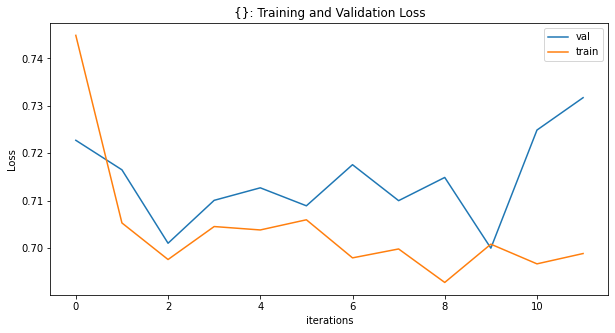

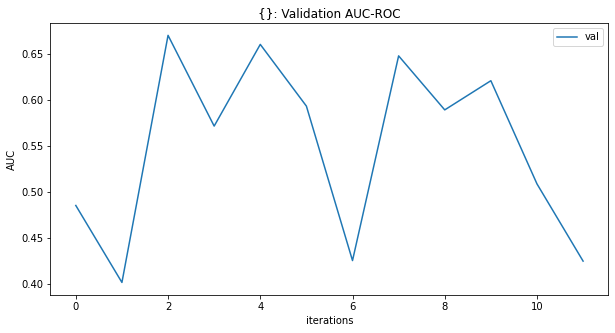

(465, 3) (117, 3)


/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,BraTS21ID,MGMT_value,MRI_Type
537,789,1,T1w
27,44,0,T1w
508,740,1,T1w
248,360,1,T1w
283,410,0,T1w


,BraTS21ID,MGMT_value,MRI_Type
289,418,0,T1w
568,836,0,T1w
484,705,1,T1w
50,78,1,T1w
40,62,1,T1w


EPOCH: 1


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 1] loss: 0.7296, time: 144.00 s
[Epoch Valid: 1] loss: 0.7236, auc: 0.3874, time: 11.00 s
auc improved from 0.0000 to 0.3874. Saved model to 'T1w-e1-loss0.724-auc0.387.pth'
EPOCH: 2


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 2] loss: 0.7057, time: 145.00 s
[Epoch Valid: 2] loss: 0.7042, auc: 0.5997, time: 11.00 s
auc improved from 0.3874 to 0.5997. Saved model to 'T1w-e2-loss0.704-auc0.600.pth'
EPOCH: 3


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 3] loss: 0.7010, time: 144.00 s
[Epoch Valid: 3] loss: 0.7180, auc: 0.3783, time: 11.00 s
EPOCH: 4


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 4] loss: 0.6997, time: 144.00 s
[Epoch Valid: 4] loss: 0.7186, auc: 0.3941, time: 10.00 s
EPOCH: 5


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 5] loss: 0.7006, time: 144.00 s
[Epoch Valid: 5] loss: 0.6910, auc: 0.5548, time: 10.00 s
EPOCH: 6


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 6] loss: 0.7018, time: 143.00 s
[Epoch Valid: 6] loss: 0.7104, auc: 0.4440, time: 10.00 s
EPOCH: 7


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 7] loss: 0.7010, time: 144.00 s
[Epoch Valid: 7] loss: 0.7126, auc: 0.5167, time: 10.00 s
EPOCH: 8


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 8] loss: 0.6967, time: 144.00 s
[Epoch Valid: 8] loss: 0.7218, auc: 0.4073, time: 10.00 s
EPOCH: 9


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 9] loss: 0.7035, time: 143.00 s
[Epoch Valid: 9] loss: 0.7257, auc: 0.4018, time: 10.00 s
EPOCH: 10


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 10] loss: 0.6998, time: 143.00 s
[Epoch Valid: 10] loss: 0.7398, auc: 0.4032, time: 10.00 s
EPOCH: 11


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 11] loss: 0.6978, time: 144.00 s
[Epoch Valid: 11] loss: 0.7160, auc: 0.4352, time: 10.00 s
EPOCH: 12


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 12] loss: 0.6919, time: 144.00 s
[Epoch Valid: 12] loss: 0.6965, auc: 0.6018, time: 10.00 s
auc improved from 0.5997 to 0.6018. Saved model to 'T1w-e12-loss0.696-auc0.602.pth'


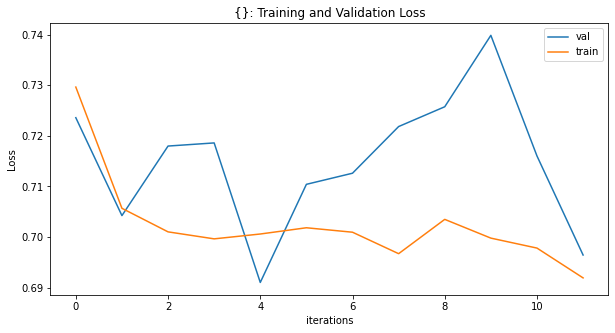

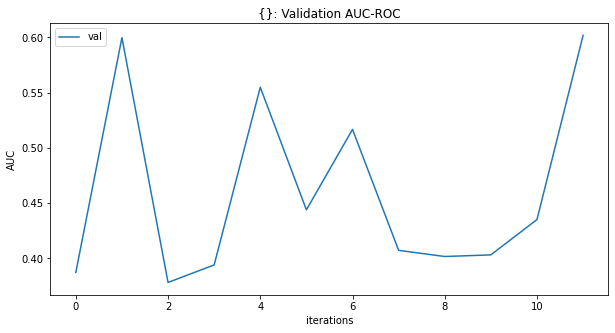

(465, 3) (117, 3)


/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,BraTS21ID,MGMT_value,MRI_Type
537,789,1,T1wCE
27,44,0,T1wCE
508,740,1,T1wCE
248,360,1,T1wCE
283,410,0,T1wCE


,BraTS21ID,MGMT_value,MRI_Type
289,418,0,T1wCE
568,836,0,T1wCE
484,705,1,T1wCE
50,78,1,T1wCE
40,62,1,T1wCE


EPOCH: 1


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 1] loss: 0.7302, time: 146.00 s
[Epoch Valid: 1] loss: 0.7238, auc: 0.4713, time: 11.00 s
auc improved from 0.0000 to 0.4713. Saved model to 'T1wCE-e1-loss0.724-auc0.471.pth'
EPOCH: 2


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 2] loss: 0.7039, time: 146.00 s
[Epoch Valid: 2] loss: 0.7186, auc: 0.5903, time: 11.00 s
auc improved from 0.4713 to 0.5903. Saved model to 'T1wCE-e2-loss0.719-auc0.590.pth'
EPOCH: 3


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 3] loss: 0.6988, time: 145.00 s
[Epoch Valid: 3] loss: 0.7058, auc: 0.5569, time: 11.00 s
EPOCH: 4


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 4] loss: 0.7043, time: 144.00 s
[Epoch Valid: 4] loss: 0.7181, auc: 0.4088, time: 10.00 s
EPOCH: 5


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 5] loss: 0.7007, time: 144.00 s
[Epoch Valid: 5] loss: 0.7222, auc: 0.4323, time: 10.00 s
EPOCH: 6


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 6] loss: 0.6944, time: 146.00 s
[Epoch Valid: 6] loss: 0.7167, auc: 0.4774, time: 10.00 s
EPOCH: 7


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 7] loss: 0.6975, time: 144.00 s
[Epoch Valid: 7] loss: 0.7096, auc: 0.4654, time: 10.00 s
EPOCH: 8


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 8] loss: 0.6986, time: 145.00 s
[Epoch Valid: 8] loss: 0.7162, auc: 0.4677, time: 10.00 s
EPOCH: 9


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 9] loss: 0.7008, time: 144.00 s
[Epoch Valid: 9] loss: 0.7126, auc: 0.5431, time: 10.00 s
EPOCH: 10


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 10] loss: 0.6947, time: 145.00 s
[Epoch Valid: 10] loss: 0.7184, auc: 0.4674, time: 10.00 s
EPOCH: 11


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 11] loss: 0.6959, time: 144.00 s
[Epoch Valid: 11] loss: 0.7083, auc: 0.5378, time: 10.00 s
EPOCH: 12


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 12] loss: 0.6957, time: 144.00 s
[Epoch Valid: 12] loss: 0.7037, auc: 0.5326, time: 10.00 s


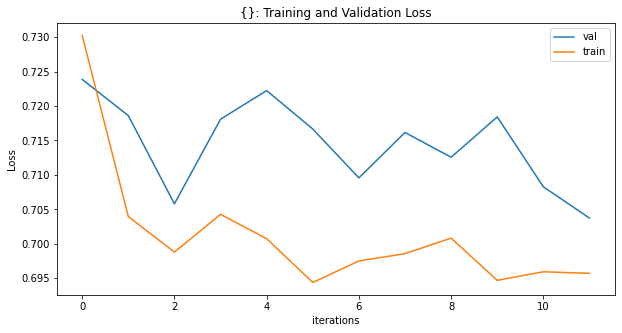

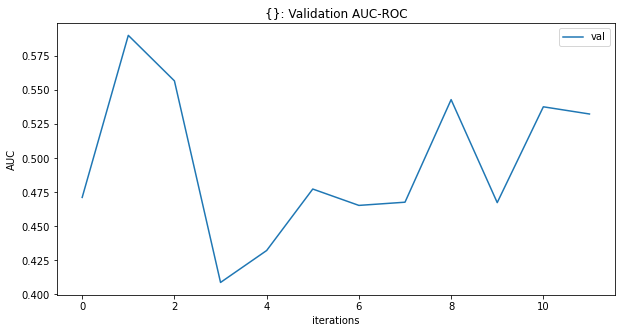

(465, 3) (117, 3)


/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,BraTS21ID,MGMT_value,MRI_Type
537,789,1,T2w
27,44,0,T2w
508,740,1,T2w
248,360,1,T2w
283,410,0,T2w


,BraTS21ID,MGMT_value,MRI_Type
289,418,0,T2w
568,836,0,T2w
484,705,1,T2w
50,78,1,T2w
40,62,1,T2w


EPOCH: 1


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 1] loss: 0.7370, time: 146.00 s
[Epoch Valid: 1] loss: 0.7230, auc: 0.5616, time: 12.00 s
auc improved from 0.0000 to 0.5616. Saved model to 'T2w-e1-loss0.723-auc0.562.pth'
EPOCH: 2


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 2] loss: 0.7069, time: 147.00 s
[Epoch Valid: 2] loss: 0.7129, auc: 0.6047, time: 11.00 s
auc improved from 0.5616 to 0.6047. Saved model to 'T2w-e2-loss0.713-auc0.605.pth'
EPOCH: 3


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 3] loss: 0.7140, time: 145.00 s
[Epoch Valid: 3] loss: 0.7121, auc: 0.5044, time: 11.00 s
EPOCH: 4


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 4] loss: 0.7035, time: 145.00 s
[Epoch Valid: 4] loss: 0.7049, auc: 0.5883, time: 10.00 s
EPOCH: 5


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 5] loss: 0.7096, time: 145.00 s
[Epoch Valid: 5] loss: 0.7150, auc: 0.5537, time: 10.00 s
EPOCH: 6


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 6] loss: 0.7019, time: 145.00 s
[Epoch Valid: 6] loss: 0.7161, auc: 0.5886, time: 10.00 s
EPOCH: 7


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 7] loss: 0.7037, time: 145.00 s
[Epoch Valid: 7] loss: 0.7111, auc: 0.6217, time: 10.00 s
auc improved from 0.6047 to 0.6217. Saved model to 'T2w-e7-loss0.711-auc0.622.pth'
EPOCH: 8


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 8] loss: 0.6981, time: 145.00 s
[Epoch Valid: 8] loss: 0.7331, auc: 0.5801, time: 10.00 s
EPOCH: 9


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 9] loss: 0.7041, time: 145.00 s
[Epoch Valid: 9] loss: 0.7084, auc: 0.6405, time: 10.00 s
auc improved from 0.6217 to 0.6405. Saved model to 'T2w-e9-loss0.708-auc0.640.pth'
EPOCH: 10


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 10] loss: 0.6966, time: 146.00 s
[Epoch Valid: 10] loss: 0.7110, auc: 0.6760, time: 10.00 s
auc improved from 0.6405 to 0.6760. Saved model to 'T2w-e10-loss0.711-auc0.676.pth'
EPOCH: 11


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 11] loss: 0.6962, time: 145.00 s
[Epoch Valid: 11] loss: 0.7121, auc: 0.6569, time: 10.00 s
EPOCH: 12


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 12] loss: 0.6951, time: 145.00 s
[Epoch Valid: 12] loss: 0.7121, auc: 0.6578, time: 10.00 s


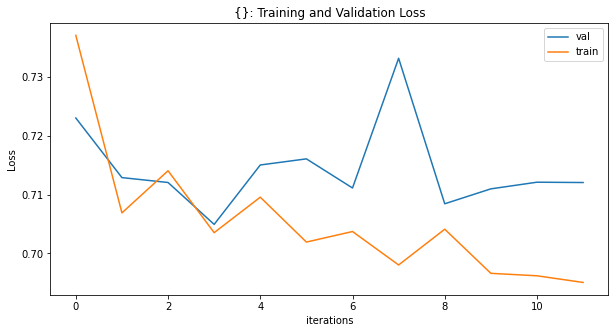

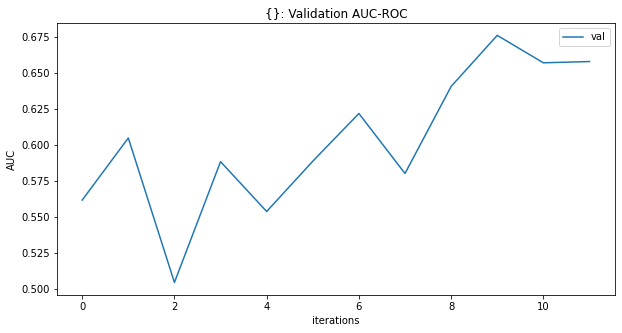

['FLAIR-e3-loss0.701-auc0.670.pth', 'T1w-e12-loss0.696-auc0.602.pth', 'T1wCE-e2-loss0.719-auc0.590.pth', 'T2w-e10-loss0.711-auc0.676.pth']


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_mri_type(df_train, df_valid, mri_type):
    if mri_type=="all":
        train_list = []
        valid_list = []
        for mri_type in mri_types:
            df_train.loc[:,"MRI_Type"] = mri_type
            train_list.append(df_train.copy())
            df_valid.loc[:,"MRI_Type"] = mri_type
            valid_list.append(df_valid.copy())

        df_train = pd.concat(train_list)
        df_valid = pd.concat(valid_list)
    else:
        df_train.loc[:,"MRI_Type"] = mri_type
        df_valid.loc[:,"MRI_Type"] = mri_type

    print(df_train.shape, df_valid.shape)
    display(df_train.head())
    display(df_valid.head())
    
    train_data_retriever = Dataset(
        df_train["BraTS21ID"].values, 
        df_train["MGMT_value"].values, 
        df_train["MRI_Type"].values
    )

    valid_data_retriever = Dataset(
        df_valid["BraTS21ID"].values, 
        df_valid["MGMT_value"].values,
        df_valid["MRI_Type"].values
    )

    train_loader = torch_data.DataLoader(
        train_data_retriever,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=8,
    )

    valid_loader = torch_data.DataLoader(
        valid_data_retriever, 
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=8,
    )

    model = build_model()
    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    criterion = torch_functional.binary_cross_entropy_with_logits

    trainer = Trainer(
        model, 
        device, 
        optimizer, 
        criterion
    )

    history = trainer.fit(
        N_EPOCHS, 
        train_loader, 
        valid_loader, 
        f"{mri_type}", 
        N_EPOCHS,
    )
    
    trainer.display_plots(mri_type)
    
    return trainer.lastmodel

modelfiles = None

if not modelfiles:
    modelfiles = [train_mri_type(df_train, df_valid, m) for m in mri_types]
    print(modelfiles)

In [15]:
def absoluteFilePaths(directory):
    files=[]
    for dirpath,_,filenames in os.walk(directory):
        for f in filenames:
             files.append(os.path.abspath(os.path.join(dirpath, f)))
    return files

In [16]:
m= os.listdir('../input/monaitrain')
m.sort(key=lambda x:x[:30])

In [17]:
'''modelfiles=[
 '/kaggle/input/monaitrain/FLAIR-e1-loss0.728-auc0.393.pth',
 '/kaggle/input/monaitrain/T1w-e1-loss0.749-auc0.463.pth',
 '/kaggle/input/monaitrain/T1wCE-e1-loss0.745-auc0.469.pth',
 '/kaggle/input/monaitrain/T2w-e1-loss0.716-auc0.581.pth']'''

"modelfiles=[\n '/kaggle/input/monaitrain/FLAIR-e1-loss0.728-auc0.393.pth',\n '/kaggle/input/monaitrain/T1w-e1-loss0.749-auc0.463.pth',\n '/kaggle/input/monaitrain/T1wCE-e1-loss0.745-auc0.469.pth',\n '/kaggle/input/monaitrain/T2w-e1-loss0.716-auc0.581.pth']"

# Prediction

In [18]:
def predict(modelfile, df, mri_type, split):
    print("Predict:", modelfile, mri_type, df.shape)
    df.loc[:,"MRI_Type"] = mri_type
    data_retriever = Dataset(
        df.index.values, 
        mri_type=df["MRI_Type"].values,
        split=split
    )

    data_loader = torch_data.DataLoader(
        data_retriever,
        batch_size=1,
        shuffle=False,
        num_workers=8,
    )
   
    model = build_model()
    model.to(device)
    
    checkpoint = torch.load(modelfile)
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()
    
    y_pred = []
    ids = []

    for e, batch in enumerate(data_loader,1):
        print(f"{e}/{len(data_loader)}", end="\r")
        with torch.no_grad():
            tmp_pred = torch.sigmoid(model(torch.tensor(batch["X"]).float().to(device)).squeeze(1)).cpu().numpy().squeeze()
            if tmp_pred.size == 1:
                y_pred.append(tmp_pred)
            else:
                y_pred.extend(tmp_pred.tolist())
            ids.extend(batch["id"].numpy().tolist())
            
    preddf = pd.DataFrame({"BraTS21ID": ids, "MGMT_value": y_pred}) 
    preddf = preddf.set_index("BraTS21ID")
    return preddf

**Validation**

In [19]:
print(modelfiles)

['FLAIR-e3-loss0.701-auc0.670.pth', 'T1w-e12-loss0.696-auc0.602.pth', 'T1wCE-e2-loss0.719-auc0.590.pth', 'T2w-e10-loss0.711-auc0.676.pth']


In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Predict: FLAIR-e3-loss0.701-auc0.670.pth FLAIR (117, 3)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Predict: T1w-e12-loss0.696-auc0.602.pth T1w (117, 3)
Predict: T1wCE-e2-loss0.719-auc0.590.pth T1wCE (117, 3)
Predict: T2w-e10-loss0.711-auc0.676.pth T2w (117, 3)
Validation ensemble AUC: 0.7053


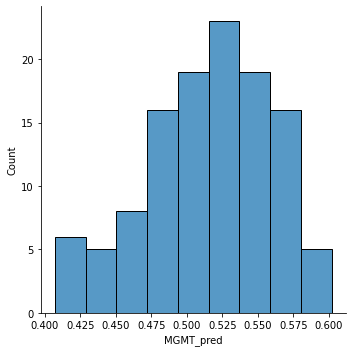

In [21]:
df_pred = df_valid.set_index("BraTS21ID")
df_pred["MGMT_pred"] = 0
for m, mtype in zip(modelfiles,  mri_types):
    pred = predict(m, df_pred, mtype, "train")
    df_pred["MGMT_pred"] += pred["MGMT_value"]
df_pred["MGMT_pred"] /= len(modelfiles)
auc = roc_auc_score(df_pred["MGMT_value"], df_pred["MGMT_pred"])
print(f"Validation ensemble AUC: {auc:.4f}")
sns.displot(df_pred["MGMT_pred"])

**Submission**

In [22]:
submission = pd.read_csv("../input/rsna-miccai-brain-tumor-radiogenomic-classification/sample_submission.csv", index_col="BraTS21ID")

submission["MGMT_value"] = 0
for m, mtype in zip(modelfiles, mri_types):
    pred = predict(m, submission, mtype, split="test")
    submission["MGMT_value"] += pred["MGMT_value"]

submission["MGMT_value"] /= len(modelfiles)
submission["MGMT_value"].to_csv("submission.csv")

Predict: FLAIR-e3-loss0.701-auc0.670.pth FLAIR (87, 1)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Predict: T1w-e12-loss0.696-auc0.602.pth T1w (87, 2)
Predict: T1wCE-e2-loss0.719-auc0.590.pth T1wCE (87, 2)
Predict: T2w-e10-loss0.711-auc0.676.pth T2w (87, 2)
